## Basic Track Analysis - PySpark
This guide performs similar actions as the "Basic Track Analysis" notebook, but it accomplishes it using PySpark, which is the Python API for Spark. By using the `run_python_script` functionality present in the ArcGIS API for Python, we can leverage Spark functionality in our GeoAnalytics Server to get faster analysis results. 

In this notebook, we'll use PySpark to examine large volumes of track data. We'll show the power of PySpark for querying, aggregating, identifying clusters, calculating new statistics, and summarizing attributes. 

This guide assumes that:
1. You are an administrator for your organization OR you are a Track Viewer that has privileges to create content.
2. You are using Enterprise 10.7+
3. You have GeoAnalytics Server as part of your Enterprise deployment
4. You are running this with the latest version of the ArcGIS API for Python

In [1]:
import arcgis
from arcgis.gis import GIS
from arcgis.apps.tracker import TrackView

arcgis.env.process_spatial_reference = "102100"

gis = GIS("https://<server>/portal", "admin", verify_cert=False)
if not arcgis.geoanalytics.is_supported(gis):
    raise Exception("GeoAnalytics is not supported for this organization")

Enter password: ········


### First, let's get familiar with our data

We'll be performing analyses on Tracker data in the Inland Empire area. We're not filtering by any particular attribute here when displaying these tracks, so the amount of track data is pretty significant - almost 450k track points.

In [2]:
tracks_layer = arcgis.apps.tracker.TrackView(gis.content.get('711e950660fc41a592bf3f84fcf179cd')).tracks_layer
print(f"Number of Tracks in LTS: {tracks_layer.query('1=1', return_count_only=True)}")

Number of Tracks in LTS: 435752



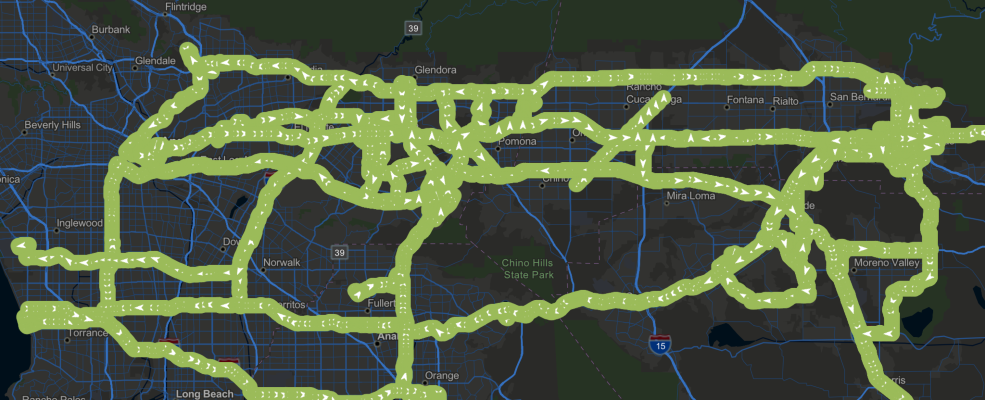

In [3]:
map1 = gis.map("Chino Hills, CA", zoomlevel=9)
map1.basemap = 'streets-night-vector'
map1.add_layer(tracks_layer)
map1

### That's a lot of tracks!
As you can see, we have a ton of tracks in the layer. That's going to make performing any of our analysis operations in GeoAnalytics take quite a bit of time. Let's return all the tracks that are walking (activity attribute == 2) and see how long it takes to do so. 

In [4]:
%%time
import datetime
tracks = tracks_layer.query("activity=2", return_all_records=True)
print(f"Number of Tracks that match criteria: {len(tracks)}")

Number of Tracks that match criteria: 46537
CPU times: user 608 ms, sys: 74.7 ms, total: 682 ms
Wall time: 5.54 s


### Now let's try that in PySpark
We'll use the `run_python_script` function available in the ArcGIS Python API to run a code block which filters those tracks. The code block contains the `filter()` function which can be performed on a Spark Dataframe.

In [5]:
%%time
import json
code = '''
import datetime
print(layers[0].filter(layers[0].activity == 2).count())
'''
x = arcgis.geoanalytics.manage_data.run_python_script(code=code, layers=[tracks_layer])
print("Number of tracks that matched criteria: " + json.loads(x[-2]['description'])['message'])

Number of tracks that matched criteria: [Python] 46537
CPU times: user 57.9 ms, sys: 6.01 ms, total: 64 ms
Wall time: 26.3 s


### No performance improvement yet...

But now, let's compare performance of several Geoanalytics tools using the standard Python API geoanalytics module and using `run_python_script`. In this example, we will created some aggregated hexagon bins to analyze where the most frequently visted locations were. We'll perform two actions in each example. 

First, we will aggregate the walking track points using the `aggregate_points` functionality in GeoAnalytics. Then, to ensure high quality data, we will filter the aggregated bins so that we return only aggregations where the mean horizontal accuracy is below 20. However, the first example will use the Python API directly, which the second example will use `run_python_script` and PySpark filter functionality. 

In [6]:
%%time
tracks_layer.filter = 'activity = 2'
from arcgis.geoanalytics.summarize_data import aggregate_points
aggregated_tracks = aggregate_points(point_layer=tracks_layer,
                         bin_size=50,
                         bin_size_unit="Meters",
                         bin_type="Hexagon")
quality_aggregated_tracks = aggregated_tracks.layers[0].query('MEAN_horizontal_accuracy < 20')

/Users/nira9586/geosaurus/src/arcgis/gis/__init__.py:3992: UserWarning: Item ID is not Support at this version. Please use version >=10.8.1 Enterprise.
  warnings.warn("Item ID is not Support at this version. Please use version >=10.8.1 Enterprise.")


CPU times: user 174 ms, sys: 19.1 ms, total: 193 ms
Wall time: 44 s


In [7]:
%%time
code_2 = '''
aggregated_tracks = geoanalytics.aggregate_points(layers[0],
                     bin_size=50,
                     bin_size_unit="Meters",
                     bin_type="Hexagon")
quality_aggregated_tracks = aggregated_tracks.filter(aggregated_tracks.MEAN_horizontal_accuracy < 20)
quality_aggregated_tracks.write.format('webgis').save('Aggregate_{0}'.format(time.time()))
'''
x = arcgis.geoanalytics.manage_data.run_python_script(code=code_2, layers=[tracks_layer])

CPU times: user 80.7 ms, sys: 7.55 ms, total: 88.2 ms
Wall time: 37.4 s



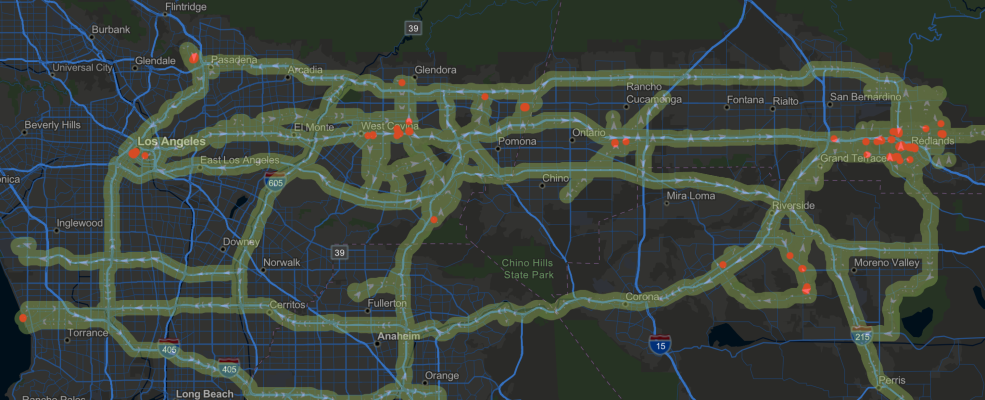

In [8]:
# visualize high-accuracy clusters
tracks_layer.filter = None
map2 = gis.map("Chino Hills, CA", zoomlevel=9)
map2.basemap = 'streets-night-vector'
map2.add_layer(quality_aggregated_tracks, {"symbol":{"color":[255,0,0,255],"size":5,"type":"esriSMS","style":"esriSMSCircle"}})
map2.add_layer(tracks_layer, {'opacity': 0.4})
map2

### Looks like run_python_script has some performance improvement!
The function gets its advantage from the fact that you don't have to write out intermediate results - the entire program is executed for you on the GeoAnalytics Server, so you only have to deal with input and output. The more functions you want to chain together, the better performance improvement you'll see!

Now, let's try a second example where we chain together even more actions. We're going to find the users in the track view with the largest range of acceleration values.

First, we'll calculate acceleration by using `calculate_fields` and the speed field. Then, we'll `summarize_attributes` to find the range of acceleration to find the users that were accelerating the most while driving. 

In [9]:
%%time
tracks_layer.filter = 'activity = 5'
from arcgis.geoanalytics.summarize_data import summarize_attributes
from arcgis.geoanalytics.manage_data import calculate_fields
acceleration_expression = """
    ($track.field["speed"].history(-2)[0] - $feature.speed)/(DateDiff($track.field["location_timestamp"].history(-2)[0], $feature.location_timestamp, "seconds"))
    """
acceleration = calculate_fields(tracks_layer,
                               "acceleration",
                               "Double",
                               acceleration_expression,
                               track_aware=True,
                               track_fields=["created_user"],
                               )
summarized_result = summarize_attributes(input_layer=acceleration.layers[0], fields="created_user", summary_fields=[{"statisticType":"Range","onStatisticField":"acceleration"}])                     

CPU times: user 231 ms, sys: 18.6 ms, total: 249 ms
Wall time: 1min 41s


In [9]:
def calculate_acceleration_range():
    acceleration_expression = """
        ($track.field["speed"].history(-2)[0] - $feature.speed)/(DateDiff($track.field["location_timestamp"].history(-2)[0], $feature.location_timestamp, "seconds"))
        """
    acceleration = geoanalytics.calculate_field(layers[0],
                                   "acceleration",
                                   "Double",
                                   acceleration_expression,
                                   track_aware=True,
                                   track_fields=["created_user"],
                                   )
    acceleration_range = geoanalytics.summarize_attributes(acceleration, fields=["created_user"], summary_fields=[{"statisticType" : "Range", "onStatisticField" : "acceleration"}])
    acceleration_range.write.format('webgis').save('Summary_{0}'.format(time.time()))

# use function as code block for run_python_script
%time x = arcgis.geoanalytics.manage_data.run_python_script(code=calculate_acceleration_range, layers=[tracks_layer])

CPU times: user 81 ms, sys: 7.12 ms, total: 88.1 ms
Wall time: 40.9 s


In [10]:
# visualize users with highest range for acceleration
acceleration_range_df = summarized_result.tables[0].query('1=1', as_df=True)
acceleration_range_df.sort_values('RANGE_acceleration', axis=0, ascending=False, inplace=True)
acceleration_range_df.head()

,created_user,COUNT,RANGE_acceleration,globalid,OBJECTID
14,anurasih,18877.0,473.209991,{65C16402-63E0-4D6D-76F0-CDD512C38993},17
11,delias,10455.0,419.880005,{80285732-810E-D938-80DD-A1A89B627922},12
1,apatel,89268.0,193.632614,{DE1FDCE6-14B2-68BC-514D-005F142D562E},2
17,nchowdhury,25222.0,59.653349,{ABA77024-4066-5A4C-3F42-29D45085BAFE},23
3,metric,37360.0,48.540001,{C9FC4706-FFB3-CF06-B083-18EC789C6FE3},4


### Summary
We saved half the time in the previous example! The more actions you chain together, the more performance improvement you'll see using `run_python_script`. Check out these resources for more with PySpark:

1. GeoAnalytics tools with PySpark: [link 1](https://developers.arcgis.com/rest/services-reference/using-geoanalytics-tools-in-pyspark.htm)
2. Working with PySpark Dataframes: [link 2](https://www.analyticsvidhya.com/blog/2016/10/spark-dataframe-and-operations/)